In [1]:
%matplotlib inline

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import math
from glob import glob

lib_path = os.path.join('../src/lib')
if not lib_path in sys.path:
    sys.path.append(lib_path)
    
lib_path = os.path.join('../src/')
if not lib_path in sys.path:
    sys.path.append(lib_path)

import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np
import torch
import json
import cv2
from PIL import Image

from utils.image import flip, color_aug
from utils.image import get_affine_transform, affine_transform
from utils.image import gaussian_radius, draw_umich_gaussian, draw_msra_gaussian
from utils.image import draw_dense_reg
from fhd_opts import opts
from datasets.dataset_factory import get_dataset
from models.decode import decode_output_4iou, decode_label_4iou

from detectors.detector_factory import detector_factory

In [3]:
minimum, maximum = 0.6, 1.4

In [4]:
def _get_border(border, size):
    i = 1
    while size - border // i <= border // i:
        i *= 2
    return border // i

In [6]:
img_path = '/data/cc/Data/CHD/detection/images/normal_0000.png'
img = cv2.imread(img_path)

In [60]:
args = ['eldet']
opt = opts().parse(args)
opt.data_dir = '/data/cc/Data/CHD/detection/'
opt.num_classes = 2
opt.dataset = 'coco_fhd'
opt.not_rand_crop = True
opt.input_h = 608
opt.input_w = 896

torch.manual_seed(opt.seed)
torch.backends.cudnn.benchmark = not opt.not_cuda_benchmark and not opt.test
Dataset = get_dataset(opt.dataset, opt.task)
opt = opts().update_dataset_info_and_set_heads(opt, Dataset)
print(opt)

Fix size testing.
training chunk_sizes: [32]
The output will be saved to  /data/cc/workspace/Repository/CenterNet/scripts/../../exp/eldet/default
heads {'hm': 2, 'reg': 2, 'l': 1, 'ratio_al': 1, 'ratio_ba': 1, 'theta': 1}
Namespace(K=2, aggr_weight=0.0, agnostic_ex=False, arch='dla_34', aug_ddd=0.5, aug_rot=0, batch_size=32, cat_spec_wh=False, center_thresh=0.1, chunk_sizes=[32], data_dir='/data/cc/Data/CHD/detection/', dataset='coco_fhd', debug=0, debug_dir='/data/cc/workspace/Repository/CenterNet/scripts/../../exp/eldet/default/debug', debugger_theme='white', demo='', dense_hp=False, dense_wh=False, dep_weight=1, dim_weight=1, down_ratio=4, ellipse_reg_weight=0, ellipse_weight=1, eval_oracle_dep=False, eval_oracle_hm=False, eval_oracle_hmhp=False, eval_oracle_hp_offset=False, eval_oracle_kps=False, eval_oracle_offset=False, eval_oracle_wh=False, exp_dir='/data/cc/workspace/Repository/CenterNet/scripts/../../exp/eldet', exp_id='default', fix_res=True, flip=0.5, flip_test=False, gpus=[

In [7]:
height, width = img.shape[0], img.shape[1]
c = np.array([img.shape[1] / 2., img.shape[0] / 2.], dtype=np.float32)
if opt.keep_res:
  input_h = (height | opt.pad) + 1
  input_w = (width | opt.pad) + 1
  s = np.array([input_w, input_h], dtype=np.float32)
else:
  s = max(img.shape[0], img.shape[1]) * 1.0
  input_h, input_w = opt.input_h, opt.input_w
  # When image is too large or too small
  minimum = 1.0 if min(img.shape[0], img.shape[1]) < 384 else 0.6
  maximum = 1.0 if min(img.shape[0], img.shape[1]) > 1024 else 1.4

print("img_shape = {}, s = {}, input_w = {}, input_h = {}, c = {}".format(img.shape, s, input_w, input_h, c))

img_shape = (661, 966, 3), s = 966.0, input_w = 512, input_h = 512, c = [483.  330.5]


In [8]:
flipped = False

io_scale = np.random.choice(np.arange(minimum, maximum, 0.1))
s = s * io_scale
w_border = _get_border(128, img.shape[1])
h_border = _get_border(128, img.shape[0])
c[0] = np.random.randint(low=w_border, high=img.shape[1] - w_border)
c[1] = np.random.randint(low=h_border, high=img.shape[0] - h_border)

if np.random.random() < opt.flip:
    flipped = True
    img = img[:, ::-1, :] 
    c[0] =  width - c[0] - 1
    
print(io_scale, s, c)

0.8999999999999999 869.3999999999999 [600. 265.]


In [9]:
mean = [0, 0, 0]
std = [1, 1, 1]
trans_input = get_affine_transform(c, s, 0, [input_w, input_h])
inp = cv2.warpAffine(img, trans_input, 
                     (input_w, input_h),
                     flags=cv2.INTER_LINEAR)
inp = (inp.astype(np.float32) / 255.)
inp = (inp - mean) / std
inp = inp.transpose(2, 0, 1)

output_h = input_h // opt.down_ratio
output_w = input_w // opt.down_ratio
num_classes = opt.num_classes
trans_output = get_affine_transform(c, s, 0, [output_w, output_h])

In [10]:
trans_input[0][0]

0.5889118767221863

In [11]:
trans_input, trans_output

(array([[ 5.88911877e-01, -0.00000000e+00, -9.73471260e+01],
        [-2.36847579e-17,  5.88911877e-01,  9.99383527e+01]]),
 array([[ 1.47227969e-01, -0.00000000e+00, -2.43367815e+01],
        [-5.92118946e-18,  1.47227969e-01,  2.49845882e+01]]))

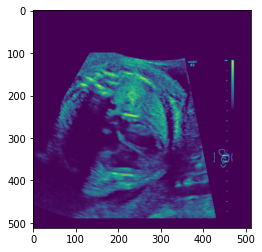

In [12]:
plt.imshow(inp[0, :])

In [106]:
image_folder = '/data/cc/Data/CHD/detection/images/'
image_list = glob(os.path.join(image_folder, "normal*.png"))
means = []
stds = []
shapes = []
ratios = []

for img_path in image_list:
    img = Image.open(img_path)
    img = np.array(img) / 255.
    means.append(img.mean())
    stds.append(img.std())
    shapes.append(img.shape)
    ratios.append(img.shape[1] / img.shape[0])


In [110]:
print("Mean shape:", np.mean(shapes, axis=0))
print("mean:", np.mean(means))
print("std:", np.mean(stds))
print("ratio:", np.mean(ratios))

Mean shape: [645.06296048 917.69390489]
mean: 0.21595953840661783
std: 0.22154049236013681
ratio: 1.4241113747947385


# Test Sampler

In [61]:
print('Setting up data...')
val_loader = torch.utils.data.DataLoader(
    Dataset(opt, 'val'), 
    batch_size=1, 
    shuffle=False,
    num_workers=1,
    pin_memory=True
)

if opt.test:
    _, preds = trainer.val(0, val_loader)
    val_loader.dataset.run_eval(preds, opt.save_dir)

train_loader = torch.utils.data.DataLoader(
    Dataset(opt, 'train'), 
    batch_size=opt.batch_size, 
    shuffle=True,
    num_workers=opt.num_workers,
    pin_memory=True,
    drop_last=True
)

Detector = detector_factory[opt.task]
opt.load_model = '/data/cc/workspace/Repository/CenterNet/exp/eldet/0203_eldet_fhd_dla_iou_newest/model_best.pth'
detector = Detector(opt)

Setting up data...
==> initializing Fetal Heart Disease val data.
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loaded val 232 samples
==> initializing Fetal Heart Disease train data.
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Loaded train 929 samples
Creating model...
loaded /data/cc/workspace/Repository/CenterNet/exp/eldet/0203_eldet_fhd_dla_iou_newest/model_best.pth, epoch 550


In [62]:
for iter_id, batch in enumerate(train_loader): # len(batch) = 6
    break

In [65]:
idx = 0
img = np.transpose(batch['input'][idx], (1, 2, 0))
img.shape

torch.Size([608, 896, 3])

tensor(-1.8646) tensor(4.7763) tensor(1.2846)


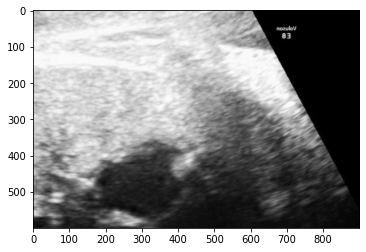

In [39]:
# idx += 1
img = np.transpose(batch['input'][idx], (1, 2, 0))
print(img.min(), img.max(), img.mean())
plt.imshow(img[:, :, 0], cmap='gray')


In [46]:
l = batch['l'][idx]
ind = batch['ind'][idx]
cx = ind // 512
cy = ind % 512
hm = batch['hm'][idx]
reg = batch['reg'][idx]
ratio_al = batch['ratio_al'][idx]
ratio_ba = batch['ratio_ba'][idx]
theta = batch['theta'][idx]


In [12]:
img = np.transpose(batch['input'][idx], (1, 2, 0)).numpy()
img = np.clip(img * 255, 0, 255).astype(np.uint8)
img.min(), img.max()

(0, 255)

In [33]:
ratio_al

0.38309577156289626

In [32]:
int(ratio_al[class_idx] * l[class_idx])

TypeError: 'float' object is not subscriptable

In [63]:
idx = 0

0 255 24.017711515115916
Ground Truth: (182, 19) (767, 604) (475, 312) tensor([584.5788]) tensor([0.3815]) 0.8385650224215246 (tensor([-0.0970]))' 223 187 -17
Ground Truth: (411, 159) (708, 456) (560, 308) tensor([297.1993]) tensor([0.4105]) 0.6721311475409836 (tensor([0.0703]))' 122 82 12


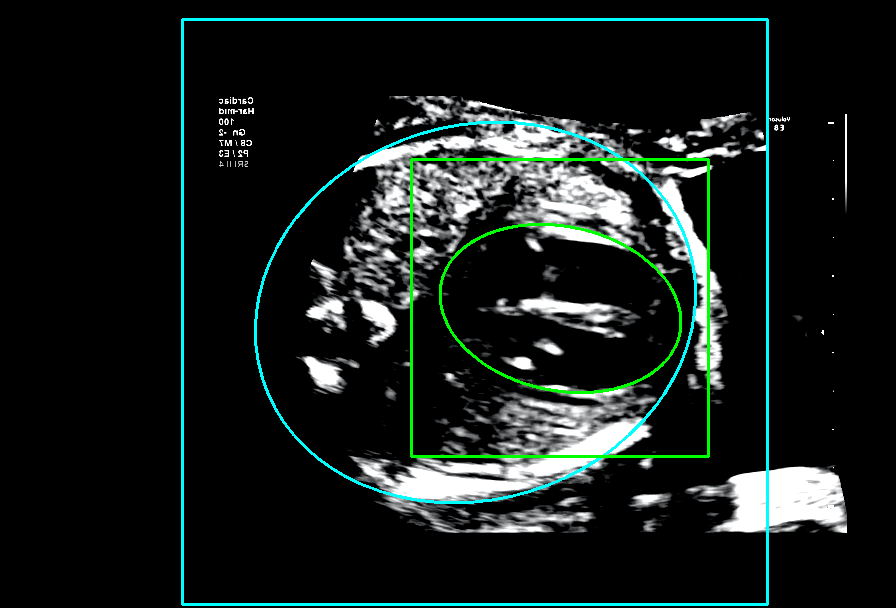

In [88]:
idx += 1

# Load Image
image = np.transpose(batch['input'][idx], (1, 2, 0)).numpy()
image = cv2.cvtColor(np.clip(image * 255, 0, 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
print(image.min(), image.max(), image.mean())
# plt.imshow(image)

# Inference
color_maps = [(0, 0, 255), (0, 255, 255), (0, 128, 0), (0, 255, 0)]

l = batch['l'][idx] * 4
ind = batch['ind'][idx]
reg = batch['reg'][idx]
cx = (ind % opt.output_res + reg[:, 0]) * 4
cy = (ind // opt.output_res + reg[:, 1]) * 4
hm = batch['hm'][idx]
ratio_als = batch['ratio_al'][idx]
ratio_bas = batch['ratio_ba'][idx]
theta = batch['theta'][idx]

for class_idx in range(2):
#     class_id = class_idx + 1
#     pt1 = (int(ret['results'][class_id][0, 0]), int(ret['results'][class_id][0, 1]))
#     pt2 = (int(ret['results'][class_id][0, 2]), int(ret['results'][class_id][0, 3]))
#     cx, cy = int(ret['results'][class_id][0, 4]), int(ret['results'][class_id][0, 5])
#     l = int(ret['results'][class_id][0, 6]) # !attention here!
#     ratio_al = ret['results'][class_id][0, 7]
#     ratio_ba = ret['results'][class_id][0, 8]
#     a = ratio_al * l
#     b = ratio_ba * a
#     theta = ret['results'][class_id][0, 9]
#     angle = theta * 180
#     print("Predict:     ", pt1, pt2, (cx, cy), l, ratio_al, ratio_ba, "({})'".format(theta), int(a), int(b), int(angle))
    
    # Annotations
    cx_gt, cy_gt = int(cx[class_idx]), int(cy[class_idx])
    a_gt = int(ratio_als[class_idx] * l[class_idx] / 2)
    b_gt = int(ratio_bas[class_idx] * a_gt)
    theta_gt = theta[class_idx]
    l_gt = l[class_idx]
#     l_gt = 2 * math.sqrt(a_gt ** 2 + b_gt ** 2)
    pt1 = (int(cx_gt - l_gt / 2), int(cy_gt - l_gt / 2))
    pt2 = (int(cx_gt + l_gt / 2), int(cy_gt + l_gt / 2))
    ratio_al, ratio_ba = a_gt / l_gt, b_gt / a_gt
    angle_gt = int(theta_gt * 180)
    print("Ground Truth:", pt1, pt2, (cx_gt, cy_gt), l_gt, ratio_al, ratio_ba, "({})'".format(theta_gt), int(a_gt), int(b_gt), int(angle_gt))
#     img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=(125, 0, 0), thickness=1)
#     img = cv2.ellipse(img, (cx_gt, cy_gt), (int(a_gt), int(b_gt)), angle_gt, 0.0, 360.0, (255, 0, 0), thickness=2)
    img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=color_maps[class_idx * 2 + 1], thickness=2)
    img = cv2.ellipse(image, (cx_gt, cy_gt), (int(a_gt), int(b_gt)), angle_gt, 0.0, 360.0, color_maps[class_idx * 2 + 1], thickness=2)
    
    
#     pt1 = (int(cx - l / 2), int(cy - l / 2))
#     pt2 = (int(cx + l / 2), int(cy + l / 2))
#     img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=color_maps[class_idx * 2], thickness=2)
#     img = cv2.ellipse(img, (cx, cy), (int(a), int(b)), angle, 0.0, 360.0, color_maps[class_idx * 2 + 1], thickness=3)
    
img = Image.fromarray(image)
img
# img.save(os.path.join('../exp/pred', img_path.split('/')[-1]))

In [93]:
batch['ratio_al'] ** 2 * (1 + batch['ratio_ba'] ** 2)

tensor([[[1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000]],

